In [258]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import integrate

# Problem 1

a) The fourth-order Runge-Kutta method has precision of $O(dx^5) = \frac{y^{(5)}}{5!} dx^5$.

For one large step $2 dx$ we have:
\begin{equation}
    y(x + 2 dx) = y_1 + \frac{y^{(5)}}{5!} (2dx)^5
\end{equation}

For two smaller steps $dx$ we have:
\begin{equation}
    y(x + 2 dx) = y_2 + \frac{y^{(5)}}{5!} 2 dx^5
\end{equation}

Now we can solve these two equations to cancel the error. Let's calculate $2^4 \cdot$(second) - (first):
\begin{equation}
    15 \cdot y(x + 2 dx) = 16 y_2 - y_1 + \frac{y^{(5)}}{5!} dx^5 (2 \cdot 2^4 - 2^5)
\end{equation}

\begin{equation}
    15 \cdot y(x + 2 dx) = 15 y_2 + (y_2 - y_1) + 0
\end{equation}

\begin{equation}
    y(x + 2 dx) = y_2 + \frac{\Delta}{15} + O(dx^6)
\end{equation}


b) The RK method with adaptive step needs 11 function evaluations, because large step and two small steps share same starting point, while basic RK method needs 8 evaluations (2 half-steps, 4 evaluations for each). Total factor will be $\frac{11}{8} = 1.375$.

In [225]:
def rk4_step(fun, x, y, h):
    k1 = fun(x, y) * h
    k2 = h * fun(x + h / 2, y + k1 / 2)
    k3 = h * fun(x + h / 2, y + k2 / 2)
    k4 = h * fun(x + h, y + k3)
    dy = (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return y + dy


def rk4_stepd(fun, x, y, h):
    # full step
    k1 = fun(x, y) * h
    k2 = h * fun(x + h / 2, y + k1 / 2)
    k3 = h * fun(x + h / 2, y + k2 / 2)
    k4 = h * fun(x + h, y + k3)
    dy = (k1 + 2 * k2 + 2 * k3 + k4) / 6

    # first half-step
    k11 = k1 / 2 #saving one func evaluation
    k12 = h / 2 * fun(x + h / 4, y + k11 / 2)
    k13 = h / 2 * fun(x + h / 4, y + k12 / 2)
    k14 = h / 2 * fun(x + h / 2, y + k13)
    dy1 = (k11 + 2 * k12 + 2 * k13 + k14) / 6
    y1 = y + dy1

    # second half-step
    k21 = fun(x + h / 2, y1) * h / 2
    k22 = h / 2 * fun(x + 0.75 * h, y1 + k21 / 2)
    k23 = h / 2 * fun(x + 0.75 * h, y1 + k22 / 2)
    k24 = h / 2 * fun(x + h, y1 + k23)
    dy2 = (k21 + 2 * k22 + 2 * k23 + k24) / 6
    delta = dy1 + dy2 - dy
    return y1 + dy2 + delta / 15, delta

In [226]:
func = lambda x, y : y / (1 + x**2)
sol = lambda x : np.exp(np.arctan(x))

y0 = 0.25
npoints = 1000

x = np.linspace(0, 5, int(npoints * 2 * 1.375)) # x2 because we are comparing two steps of basic rk4 to 1 step of adapting rk4
h = np.median(np.diff(x))
y = np.zeros(len(x))
y[0] = y0

for i in range(1, len(x)):
    y[i] = rk4_step(func, x[i-1], y[i-1], h)

x_ad = np.linspace(0, 5, npoints)
h_ad = np.median(np.diff(x_ad))
y_ad = np.zeros(len(x_ad))
delta = np.zeros(len(x_ad))
y_ad[0] = y0

for i in range(1, len(x_ad)):
    y_ad[i], delta[i] = rk4_stepd(func, x_ad[i-1], y_ad[i-1], h_ad)

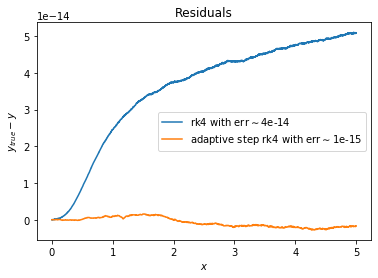

In [227]:
y_diff = y0 * sol(x) - y
y_ad_diff = y0 * sol(x_ad) - y_ad

rk4_err = np.sqrt(np.mean(y_diff**2))
rk4_ad_err = np.sqrt(np.mean(y_ad_diff**2))

plt.plot(x, y_diff, label=fr"rk4 with err$\sim${rk4_err:.0e}")
plt.plot(x_ad, y_ad_diff, label=fr"adaptive step rk4 with err$\sim${rk4_ad_err:.0e}")
plt.ylabel(r"$y_{true} - y$")
plt.xlabel(r"$x$")
plt.title("Residuals")
plt.legend()
plt.savefig('problem_1.png', dpi=500)

# Problem 2

a) This type of equation is the Stiff equation, which requires implisit method of integration to be used. For this problem I use Radau method, which is already implemented in `scipy.integrate.solve_ivp`.

b) For $U_{238}$ we have:
\begin{equation}
    \frac{dN_{U_{238}}}{dt} = -\lambda_0 N_{U_{238}} 
\end{equation}

Solution:
\begin{equation}
    N_{U_{238}} = N_0 e^{-\lambda_0 t}
\end{equation}

Where $N_0$ - total number of nuclea. For $N_0$ we use constrain:
\begin{equation}
    N_0 = N_{U_{238}} + N_{Po_{210}}
\end{equation}
\begin{equation}
    N_{U_{238}} e^{\lambda_0 t} = N_{U_{238}} + N_{Po_{210}}
\end{equation}
\begin{equation}
    \frac{N_{Po_{210}}}{N_{U_{238}}} = e^{\lambda_0 t} - 1 
\end{equation}

Last equation is the analitical solution for $\frac{N_{Po_{210}}}{N_{U_{238}}}$ ratio, which fits calculated values very well (see plots below).

P.S. I don't care about $ln(2)$ in the exponent, but it could be easily implemented.

In [228]:
# in microseconds
t12 = {
    'U-238'  : 1.40902848e+20,
    'Th-234' : 2.08224e+9,
    'Pa-234' : 2.412e+7,
    'U-234'  : 7.742088e+15,
    'Th-230' : 2.377184e+15,
    'Ra-226' : 5.045760e+13,
    'Rn-222' : 3.303504e+08,
    'Po-218' : 1.860000e+05,
    'Pb-214' : 1.608000e+06,
    'Bi-214' : 1.194000e+06,
    'Po-214' : 164.3,
    'Pb-210' : 7.032528e+11, 
    'Bi-210' : 1.581530e+11,
    'Po-210' : 1.195569e+10
}

hl = np.array(list(t12.values())) / np.log(2)
names = list(t12.keys()) + ['Pb-206']


def decay(t, n, hl):
    dndt = np.empty(len(hl) + 1)
    dndt[0] = - n[0] / hl[0]
    dndt[1:-1] = n[:-2] / hl[:-1] - n[1:-1] / hl[1:]
    dndt[-1] = n[-2] / hl[-1]
    return dndt

In [229]:
y0 = np.zeros(len(t12) + 1)
y0[0] = 1

t0 = 0
t1 = 2 * hl[0]
t = np.linspace(t0, t1, 1000000)

res = integrate.solve_ivp(
    lambda t, n: decay(t, n, hl), 
    [t0, t1], 
    y0,
    method='Radau',
    t_eval = t,
)

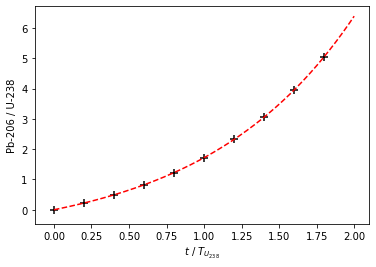

In [230]:
plt.plot(t / hl[0], res.y[-1] / res.y[0], c='r', linestyle='--')
plt.scatter(t[::100000] / hl[0], (np.exp(t / hl[0]) - 1)[::100000], marker='+', c='k', s=70)
plt.ylabel(f"{names[-1]} / {names[0]}")
plt.xlabel(r"$t$ / $T_{U_{238}}$")
plt.savefig('problem_2_1.png', dpi=500)

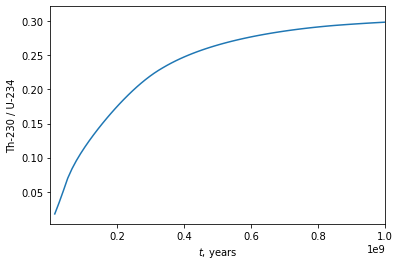

In [231]:
plt.plot(t[1:] / 60 / 60 / 24 / 365, res.y[4][1:] / res.y[3][1:])
plt.ylabel(f"{names[4]} / {names[3]}")
plt.xlabel(r"$t$, years")
plt.xlim([1e3, 1e9])
plt.savefig('problem_2_2.png', dpi=500)

# Problem 3

a) 
\begin{equation}
    z - z_0 = a((x - x_0)^2 + (y - y_0)^2)
\end{equation}
\begin{equation}
    z = a(x^2 + y^2) - 2ax_0x + ax_0^2 - 2ay_0y + ay_0^2 + z_0
\end{equation}
\begin{equation}
    z = A(x^2 + y^2) + Bx + Cy + D
\end{equation}

Here:

$
    A = a
$

$
    B = -2 a x_0 = -2Ax_0 \rightarrow x_0 = -\frac{B}{2A}
$

$
    C = -2 a y_0 = -2Ay_0 \rightarrow y_0 = -\frac{C}{2A}
$

$
D = ax_0^2 + ay_0^2 + z_0 \rightarrow D - \frac{B^2 + C^2}{4A}
$

b) For this part I assumed $N = I$.

$
A^TN^{-1}(d-Am)=0
$

$
A = USV^T
$

...

$
m = VS^{-1}U^Td
$

c) $
f = \frac{1}{4a}
$

$
\Delta f = \sqrt{\left(\frac{1}{4a^2}\right)^2 \Delta a^2} = \frac{\Delta a}{4 a^2}
$

In [382]:
data = np.loadtxt('dish_zenith.txt')
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

A = np.empty([len(data), 4])
A[:, 0] = 1
A[:, 1] = y
A[:, 2] = x
A[:, 3] = x**2 + y**2

A = A
d = z.transpose()
u, s, vt = np.linalg.svd(A, False)
sinv = np.diag(1. / s)
m = vt.transpose() @ sinv @ u.transpose() @ d

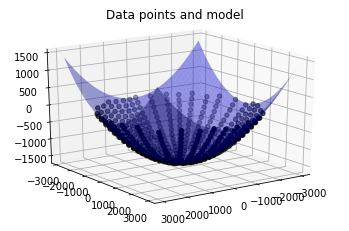

In [384]:
# Plotting
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, color='k');

n = 50
xmod = np.linspace(np.min(x), np.max(x), n)
xmod = np.repeat(xmod, n)
xmod = np.reshape(xmod, [n, n])
ymod = np.linspace(np.min(y), np.max(y), n)
ymod = np.tile(ymod, n)
ymod = np.reshape(ymod, [n, n])

zmod = np.ones([n, n]) * m[0] + ymod * m[1] + xmod * m[2] + (xmod**2 + ymod**2) * m[3]
ax.plot_surface(xmod, ymod, zmod, color='b', alpha=0.4)
plt.title("Data points and model")

ax.view_init(20, 55)
plt.savefig('problem_3_1.png', dpi=500)

In [381]:
zm = A @ m
diff = z - zm 
N = np.diag(np.repeat(np.std(diff)**2, len(data)))
cov = np.linalg.pinv(A.transpose() @ np.linalg.pinv(N) @ A)
m_err = np.sqrt(np.diag(cov))

f = 1 / (4 * m[-1])
df = m_err[-1] / (4 * m[-1]**2)
print(f"Obtaned focal length f = {f:.2f} +- {df:.2f}")

Obtaned focal length f = 1499.66 +- 0.58
